# Unit 2 Kaggle Project Notebook

## Objectives



* Prepare probabilities table for prediction categories
* Prepare confusion matrix for prediction categories
* Convert confusion matrix into percentages?
    * False positives on 'functional' are highest priority
    * False positives on 'functional needs repair' that are true 'not functional' are next highest priority
    * Calculate sensitivity and specificity?
* Update training set probabilities using new percentages?
    * Bayes Theorem? Some variant?
* Compare prior probabilities to updated probabilities
    * Prior probabilities: Initial training and validation sets
    * Updated probabilities: Training and validation sets with theorem applied



## Navigate to folder with data csv's

In [ ]:
# Mounts Google Drive in Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Navigate to folder with necessary files
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
# Check that needed files are in folder
!ls

basic_dt_prediction.csv			 sample_submission.csv
basic_rf_custom_analysis_prediction.csv  submission_baseline.csv
basic_rfcv_prediction.csv		 test_features.csv
basic_rf_prediction.csv			 train_features.csv
kaggle.json				 train_labels.csv


## Import Libraries

In [ ]:
# install updated versions of libraries
%%capture
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

In [ ]:
# import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

## Data Science Zone!

### Data Wrangling and EDA

In [ ]:
# wrangles csv's into dataframe format
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Create pump_age column
    # yields negative values, keep 'construction_year'
    # df['pump_age'] = df['recorded_year'] - df['construction_year']    
    # df.insert(14, 'pump_age', pump_age)   

    # Drop unnecessary columns
    df.drop(columns= 
    ['amount_tsh',
    'date_recorded',
    'funder',
    'gps_height',
    'installer',
    'wpt_name',
    'num_private',
    'subvillage',
    'ward',
    'recorded_by',
    'scheme_name',
    'extraction_type',
    'extraction_type_class',
    'management',
    'payment_type',
    'quality_group',
    'quantity_group',
    'source_type',
    'source_class',
    'waterpoint_type_group'],
    inplace=True)    

    # convert int and bool columns to objects for null fills
    df['region_code'] = df['region_code'].astype(object)
    df['district_code'] = df['district_code'].astype(object)
    df['public_meeting'] = df['public_meeting'].astype(object)
    df['permit'] = df['permit'].astype(object)

    # fill category nulls with specified values
    df['region_code'].fillna('null', inplace=True)
    df['district_code'].fillna('null', inplace=True)
    df['public_meeting'].fillna('null', inplace=True)
    df['permit'].fillna('null', inplace=True)
    df['scheme_management'].fillna('other_null', inplace=True)

    return df

In [ ]:
# ENGINEER
    # age
        # NULLS (float) (mean)
# KEEP
    # latitude
        # NULLS (accounted for)
    # longitude
        # NULLS (accounted for)
    # basin
    # region
    # region_code
        # NULLS (int, categorical) (null) (convert to object)
    # district_code
        # NULLS (int, categorical) (null) (convert to object)
    # lga
    # population
        # NULLS (int) (mean)
    # public_meeting
        # NULLS (bool) (null)
    # scheme_management
        # NULLS (categorical) (other_null)
    # permit
        # NULLS (bool) (null)
    # extraction_type_group
    # management_group
    # payment
    # water_quality
    # quantity
    # source
    # waterpoint_type
# DROP
    # amount_tsh
    # date_recorded
    # construction_year
    # funder
    # gps_height
    # installer
    # wpt_name
    # num_private
    # subvillage
    # ward
    # recorded_by
    # scheme_name
    # extraction_type
    # extraction_type_class
    # management
    # payment_type
    # quality_group
    # source_type, source_class
    # waterpoint_type_group

In [ ]:
# call wrangle function on csv's
df = wrangle('train_features.csv', 'train_labels.csv')
X_test = wrangle('test_features.csv')

In [ ]:
# preview usable data
df.head()

,longitude,latitude,basin,region,region_code,district_code,lga,population,public_meeting,scheme_management,permit,construction_year,extraction_type_group,management_group,payment,water_quality,quantity,source,waterpoint_type,status_group
id,,,,,,,,,,,,,,,,,,,,
454.0,35.426020,-4.227446,Internal,Manyara,21,1.0,Babati,160.0,True,Water Board,True,1998.0,gravity,user-group,pay per bucket,soft,insufficient,spring,communal standpipe,functional
510.0,35.510074,-5.724555,Internal,Dodoma,1,6.0,Bahi,NaN,True,VWC,True,NaN,india mark ii,user-group,never pay,soft,enough,shallow well,hand pump,functional
14146.0,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,Mbozi,NaN,True,VWC,False,NaN,other,user-group,never pay,soft,enough,shallow well,other,non functional
47410.0,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,Mbarali,NaN,True,VWC,True,NaN,gravity,user-group,pay monthly,soft,insufficient,river,communal standpipe,non functional
1288.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,Kilosa,120.0,True,VWC,True,1997.0,other,user-group,pay when scheme fails,salty,enough,shallow well,other,non functional


In [ ]:
print(df.shape)
df.info()

(47519, 20)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 47519 entries, 454.0 to 23812.0
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   longitude              46086 non-null  float64
 1   latitude               46086 non-null  float64
 2   basin                  47519 non-null  object 
 3   region                 47519 non-null  object 
 4   region_code            47519 non-null  int64  
 5   district_code          47519 non-null  object 
 6   lga                    47519 non-null  object 
 7   population             30472 non-null  float64
 8   public_meeting         47519 non-null  object 
 9   scheme_management      47519 non-null  object 
 10  permit                 47519 non-null  object 
 11  construction_year      31017 non-null  float64
 12  extraction_type_group  47519 non-null  object 
 13  management_group       47519 non-null  object 
 14  payment                47519 non-n

In [ ]:
# separates feature matrix and target vector
X = df.drop(columns= ['status_group'])
y = df['status_group']

### Modeling and Tuning

In [ ]:
# creates required sets
# X_train, X_val_, y_train, y_val_ = train_test_split(X, y, test_size= 0.3, random_state= 42)
# X_cM, X_val, y_cM, y_val = train_test_split(X_val_, y_val_, test_size= 0.5, random_state= 42)

NOTE: Baseline accuracy for this notebook will be different since our focus is to determine the pumps which are 'not functional' or 'functional needs repair'

In [ ]:
# baseline accuracy
baseline_acc = y.value_counts(normalize= True).max()
print('Baseline Accuracy Scores:\n', baseline_acc)

Baseline Accuracy Scores:
 0.5429828068772491


In [ ]:
# creates model
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs= -1, random_state= 42)
)

In [ ]:
param_grid = {
    'simpleimputer__strategy' : ['mean', 'median', 'most_frequent'],
    # 'randomforestclassifier__max_depth' : range(12, 26, 2),
    'randomforestclassifier__n_estimators' : range(70, 110, 10),
    'randomforestclassifier__max_leaf_nodes' : range(100, 300, 25)
}

model_rfrs = RandomizedSearchCV(
    model_rf,
    param_distributions= param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [ ]:
model_rfrs.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_leaf_nodes': range(100, 300, 25),
                                        'randomforestclassifier__n_estimators': range(70, 110, 10),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median',
                                                                    'most_frequent']},
                   verbose=1)

In [ ]:
print(model_rfrs.best_score_)
print(model_rfrs.best_params_)

0.7721120629636362
{'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 90, 'randomforestclassifier__max_leaf_nodes': 275}


In [ ]:
model_rf_tuned = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(max_depth=19,
                           n_estimators=81,
                           n_jobs=-1,
                           random_state=42)
)

In [ ]:
cv_score_rf_tuned = cross_val_score(model_rf_tuned, X, y, cv=10, n_jobs=-1)

In [ ]:
print('Cross Validation Mean Accuracy:', cv_score_rf_tuned.mean())
print('Cross Validation StDev Accuracy:', cv_score_rf_tuned.std())

Cross Validation Mean Accuracy: 0.8052357398442433
Cross Validation StDev Accuracy: 0.0031522638381931


In [ ]:
model_rf_tuned.fit(X, y)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'district_code', 'lga',
                                      'public_meeting', 'scheme_management',
                                      'permit', 'extraction_type_group',
                                      'management_group', 'payment',
                                      'water_quality', 'quantity', 'source',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Internal                   1
Lake Rukwa                 2
Rufiji                     3
Wami / Ruvu                4
Lake Victo...
unknown                 10
NaN                     -2
dtype: int64},
                                         {'col': 'waterpoint_type',
                                          'data_type': dtype('O'),
                  

In [ ]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(
                 random_state=42,
                 n_jobs=-1)
)

In [ ]:
xgb_param_grid = {
    'simpleimputer__strategy' : ['mean', 'median'],
    'xgbclassifier__max_depth' : range(1, 11, 3),
    'xgbclassifier__n_estimators' : range(50, 151, 50),
    'xgbclassifier__learning_rate' : [0.01, 0.1, 0.2, 0.3]
}

model_xgb_gs = GridSearchCV(
    model_xgb,
    param_grid = xgb_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [ ]:
model_xgb_gs.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('xgbclassifier',
                                        XGBClassifier(n_jobs=-1,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'simpleimputer__strategy': ['mean', 'median'],
                         'xgbclassifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'xgbclassifier__max_depth': range(1, 11, 3),
                         'xgbclassifier__n_estimators': range(50, 151, 50)},
             verbose=1)

In [ ]:
print(model_xgb_gs.best_score_)
print(model_xgb_gs.best_params_)

0.8041414575443303
{'simpleimputer__strategy': 'median', 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 150}


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_rf_tuned.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'district_code', 'lga',
                                      'public_meeting', 'scheme_management',
                                      'permit', 'extraction_type_group',
                                      'management_group', 'payment',
                                      'water_quality', 'quantity', 'source',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Internal                   1
Lake Rukwa                 2
Rufiji                     3
Wami / Ruvu                4
Lake Victo...
unknown                 10
NaN                     -2
dtype: int64},
                                         {'col': 'waterpoint_type',
                                          'data_type': dtype('O'),
                  

In [ ]:
perm_imp = permutation_importance(model_rf_tuned, X_val, y_val, n_repeats=10, random_state=42)

In [ ]:
perm_data = {
    'imp_mean' : perm_imp['importances_mean'],
    'imp_std' : perm_imp['importances_std']
}

df_perm = pd.DataFrame(perm_data, index=X_val.columns).sort_values('imp_mean')
df_perm

,imp_mean,imp_std
management_group,-0.000537,0.000625
basin,-0.000042,0.001006
region_code,0.001042,0.000641
permit,0.001883,0.001169
water_quality,0.001926,0.000756
public_meeting,0.002557,0.000610
scheme_management,0.002925,0.001098
district_code,0.005482,0.000981
region,0.005629,0.001174
lga,0.008880,0.001327


### Preparing Predictions

In [ ]:
y_pred = model_rf_tuned.predict(X_test)
y_pred

array(['non functional', 'functional', 'functional', ...,
       'non functional', 'non functional', 'functional'], dtype=object)

In [ ]:
rf_custom_analysis_prediction = pd.Series(y_pred, index= X_test.index, name='status_group')
rf_custom_analysis_prediction

id
37098    non functional
14530        functional
62607        functional
46053    non functional
47083        functional
              ...      
26092        functional
919          functional
47444    non functional
61128    non functional
8075         functional
Name: status_group, Length: 11880, dtype: object

In [ ]:
rf_custom_analysis_prediction.to_csv('basic_rf_custom_analysis_prediction.csv')

In [ ]:
!ls

basic_dt_prediction.csv			 sample_submission.csv
basic_rf_custom_analysis_prediction.csv  submission_baseline.csv
basic_rfcv_prediction.csv		 test_features.csv
basic_rf_prediction.csv			 train_features.csv
kaggle.json				 train_labels.csv


In [ ]:
importances = model_rf_tuned.named_steps['randomforestclassifier'].feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Feature Importances in Tuned Random Forest Model');

### Train - Validation

In [ ]:
# accuracy values for training and validation sets in initial model
training_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9955806752247242
Validation Accuracy Score: 0.7932098765432098


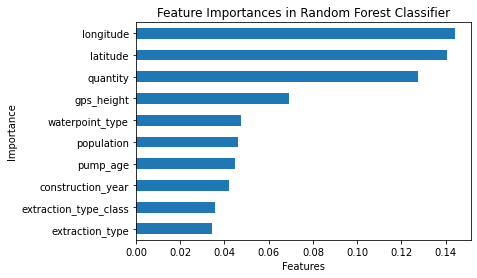

In [ ]:
# Make a horizontal bar chart of the most important features in model
features = X_train.columns
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_
feat_imp = pd.Series(data= gini, index= features).sort_values(key= abs).tail(10).plot(kind= 'barh')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Random Forest Classifier');

---
---
# !!! STOP! Cells below are for testing only !!!
---
---


In [ ]:
# drops duplicate column not captured by wrangle function
X_test.drop(columns= ['waterpoint_type_group'], inplace= True)

In [ ]:
# prediction for test data
y_pred = model_rf.predict(X_test)
assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

---
# Workshop
---

In [ ]:
# create full dataframe of training data
dff = pd.merge(pd.read_csv('train_labels.csv').set_index('id'), pd.read_csv('train_features.csv').set_index('id'), left_index=True, right_index=True)

In [ ]:
dff.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454,functional,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,Internal,Bashnet Kati,Manyara,21,1,Babati,Bashinet,160,True,GeoData Consultants Ltd,Water Board,NaN,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
510,functional,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,Internal,Lukali,Dodoma,1,6,Bahi,Lamaiti,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14146,non functional,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,Lake Rukwa,Chawalikozi,Mbeya,12,6,Mbozi,Ndalambo,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
47410,non functional,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,Rufiji,Shuleni,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1288,non functional,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,Wami / Ruvu,Ngholong,Morogoro,5,1,Kilosa,Chakwale,120,True,GeoData Consultants Ltd,VWC,NaN,True,1997,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [ ]:
# dataframe info
print(dff.shape)
dff.info()

(47520, 40)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           47520 non-null  object 
 1   amount_tsh             47520 non-null  float64
 2   date_recorded          47520 non-null  object 
 3   funder                 44644 non-null  object 
 4   gps_height             47520 non-null  int64  
 5   installer              44631 non-null  object 
 6   longitude              47520 non-null  float64
 7   latitude               47520 non-null  float64
 8   wpt_name               47520 non-null  object 
 9   num_private            47520 non-null  int64  
 10  basin                  47520 non-null  object 
 11  subvillage             47224 non-null  object 
 12  region                 47520 non-null  object 
 13  region_code            47520 non-null  int64  
 14  district_code          47520 non-null  i

In [ ]:
dff.isnull().sum()

status_group                 0
amount_tsh                   0
date_recorded                0
funder                    2876
gps_height                   0
installer                 2889
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 296
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2689
recorded_by                  0
scheme_management         3102
scheme_name              22523
permit                    2439
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

## Column Analysis

In [ ]:
# amount_tsh: total static head (distance between water source/pump/waterpoint)
    # DROP, sample sizes too heavily skewed (noise)
    # zeros will be considered as open tanks or closed circulation systems.

# date_recorded, construction_year: the date the row was entered / date pump constructed
    # age predicted to heavily impact category
    # date_recorded assumed to be the date the pump was inspected
    # age should be date recorded year - construction date year (instead of current year - construction year)
        # ABOVE CALCULATION YIELDS NEGATIVE VALUES, KEEP CONSTRUCTION YEAR

# funder: who funded the well
    # DROP, sample sizes too heavily skewed (noise)
    # intitial investigation shows minimal impact

# gps_height: altitude of the well
    # DROP, sample sizes too small for all categories (noise)
    # altitude baseline unclear. From sea level? From ground at location?
    # units unclear. feet? meters?

# installer: well installer
    # DROP, sample sizes too small for all categories (noise)
    # same thing as pump installer?

# latitude and longitude: gps coordinates
    # preliminary models show significant impact to category
    # need to perform a map visualization to better understand
        # tableau best suited?

# wpt_name: waterpoint name
    # DROP, sample sizes too heavily skewed (noise)

# num_private: ???
    # DROP, sample sizes too heavily skewed (noise)
    # appears to be categorical integers
    # unable to interpret due to lack of description

# basin, subvillage, region, region_code, district_code, ward: geographic details
    # KEEP: basin, region, region_code, district_code
    # DROP: subvillage
    # unknown impact to category
    # likely able to be dropped in lieu of lat/long data (may even cause noise)
        # only possible significant impact is if maintenance is done by different groups,
        # which may be different by region

# lga: local government area
    # slight to moderate impact to category
    # KEEP, sample sizes sufficient
    # likely able to be dropped (may even cause noise)
    # possible impact (see basin, etc. above)

# population: population around the well
    # possible significant impact to category
    # KEEP, int column
        # the more people using the pump, the faster it deteriorates?

# public_meeting: ???
    # slight impact to category
    # WATCH FOR NULL VALUES
    # whether or not a public meeting was held?
    # for what reason? installation?

# recorded_by: group recording this data
    # DROP, constant column (1 group)

# scheme_management, scheme_name: who operates the pump
    # slight to moderate impact to category
    # KEEP, use scheme management, sample sizes sufficient
    # WATCH FOR NULL VALUES
    # same group who maintains the pump ?
    # scheme_management and scheme_name are different? management oversees name?

# permit: if the waterpoint is permitted
    # slight impact to category
    # WATCH FOR NULL VALUES
    # why would unpermitted waterpoints be allowed to exist?
    # 3-4% more non-functional wells for non-permitted waterpoints

# extraction_type, extraction_type_group, extraction_type_class: extraction type at waterpoint
    # slight to moderate impact to category
    # analysis shows extraction_type_group to be the optimal balance of sample size for each extraction type category

# management, management_group: group type managing waterpoint
    # slight to moderate impact to category
    # analysis shows management_group to be more specific, has reasonable sample sizes, and is category-encoding-manageable

# payment, payment_type: payment required for water
    # slight to moderate impact to category
    # duplicate columns, using payment for readability

# water_quality, quality_group: quality of water
    # slight to moderate impact to category
    # using water_quality, contains abandoned wells

# quantity, quantity_group: quantity of water
    # moderate to significant impact to category
    # using quantity, duplicate columns with same names

# source, source_type, source_class: source of water
    # slight to moderate impact to category
    # analysis shows source to be more specific, has reasonable sample sizes, and is category-encoding-manageable

# waterpoint_type, waterpoint_type_group: type of waterpoint
    # slight impact to category
    # analysis shows waterpoint_type to be slightly more specific

In [ ]:
# ENGINEER
    # age
        # NULLS (float) (mean)
# KEEP
    # latitude
        # NULLS (accounted for)
    # longitude
        # NULLS (accounted for)
    # construction_year
        # NULLS (int/float) (mean)
    # basin
    # region
    # region_code
        # NULLS (int, categorical) (null) (convert to object)
    # district_code
        # NULLS (int, categorical) (null) (convert to object)
    # lga
    # population
        # NULLS (int) (mean)
    # public_meeting
        # NULLS (bool) (null)
    # scheme_management
        # NULLS (categorical) (other_null)
    # permit
        # NULLS (bool) (null)
    # extraction_type_group
    # management_group
    # payment
    # water_quality
    # quantity
    # source
    # waterpoint_type
# DROP
    # amount_tsh
    # date_recorded
    # funder
    # gps_height
    # installer
    # wpt_name
    # num_private
    # subvillage
    # recorded_by
    # scheme_name
    # permit
    # extraction_type
    # extraction_type_class
    # management
    # payment_type
    # quality_group
    # source_type, source_class
    # waterpoint_type_group

In [ ]:
# possible multicollinearity:
    # latitude, longitude, lga, basin, region, region_code, district_code
    # scheme_management, management_group, (payment_type?)
    # extraction_type_group, basin, source, waterpoint_type, water_quality, water_quantity

### Column Analysis Support

In [ ]:
# dataframe: 'funder' value counts < 100
dff_fund_less_100 = dff.groupby(by= 'funder').filter(lambda x: len(x) < 100)

In [ ]:
# details of funders who funded < 100 pumps
print(dff_fund_less_100.shape)
dff_fund_less_100['status_group'].value_counts(normalize=True)

(11462, 40)


functional                 0.542983
non functional             0.384078
functional needs repair    0.072939
Name: status_group, dtype: float64

In [ ]:
# details of full dataframe for comparison 
dff['status_group'].value_counts(normalize= True)

functional                 0.596318
non functional             0.345228
functional needs repair    0.058454
Name: status_group, dtype: float64

In [ ]:
# dataframe: 'installer' value counts < 100
dff_installer_less_100 = dff.groupby(by= 'installer').filter(lambda x: len(x) < 100)

In [ ]:
# details of installers who installed < 100 pumps
print(dff_installer_less_100.shape)
dff_installer_less_100['status_group'].value_counts(normalize=True)

(12330, 40)


functional                 0.556853
non functional             0.387429
functional needs repair    0.055718
Name: status_group, dtype: float64

In [ ]:
# dataframe: waterpoint not permitted
permit_false = dff.loc[dff['permit'] == False]

In [ ]:
print(permit_false.shape)
permit_false['status_group'].value_counts(normalize=True)

(14053, 40)


functional                 0.519533
non functional             0.404896
functional needs repair    0.075571
Name: status_group, dtype: float64

In [ ]:
# dataframe: waterpoint permitted
permit_true = dff.loc[dff['permit'] == True]

In [ ]:
print(permit_true.shape)
permit_true['status_group'].value_counts(normalize=True)

(31028, 40)


functional                 0.553436
non functional             0.376628
functional needs repair    0.069937
Name: status_group, dtype: float64

In [ ]:
# extraction type columns analysis
dff_extract = dff[['status_group','extraction_type', 'extraction_type_group', 'extraction_type_class']]

dff_extract.head()

,status_group,extraction_type,extraction_type_group,extraction_type_class
id,,,,
454,functional,gravity,gravity,gravity
510,functional,india mark ii,india mark ii,handpump
14146,non functional,other,other,other
47410,non functional,gravity,gravity,gravity
1288,non functional,other,other,other


In [ ]:
# number of unique values for extraction type columns
print(dff['extraction_type'].nunique())
print(dff['extraction_type_group'].nunique())
print(dff['extraction_type_class'].nunique())

18
13
7


In [ ]:
# category differences and sample differences
print(dff_extract[dff['extraction_type'] == dff['extraction_type_group']]['status_group'].shape)
print(dff_extract[dff['extraction_type'] == dff['extraction_type_group']]['status_group'].value_counts(normalize=True))
print(dff_extract[dff['extraction_type'] != dff['extraction_type_group']]['status_group'].shape)
print(dff_extract[dff['extraction_type'] != dff['extraction_type_group']]['status_group'].value_counts(normalize=True))
print(dff_extract[dff['extraction_type'] == dff['extraction_type_class']]['status_group'].shape)
print(dff_extract[dff['extraction_type'] == dff['extraction_type_class']]['status_group'].value_counts(normalize=True))

(45556,)
functional                 0.54388
non functional             0.38153
functional needs repair    0.07459
Name: status_group, dtype: float64
(1964,)
functional                 0.521894
non functional             0.443483
functional needs repair    0.034623
Name: status_group, dtype: float64
(30341,)
functional                 0.518935
non functional             0.398965
functional needs repair    0.082100
Name: status_group, dtype: float64


In [ ]:
# showing differing values for extraction type columns
dff_extract.loc[dff['extraction_type'] != dff['extraction_type_group']]

,status_group,extraction_type,extraction_type_group,extraction_type_class
id,,,,
12676,non functional,ksb,submersible,submersible
65651,functional,ksb,submersible,submersible
14326,functional,windmill,wind-powered,wind-powered
40339,functional,ksb,submersible,submersible
50874,non functional,ksb,submersible,submersible
...,...,...,...,...
45105,functional,ksb,submersible,submersible
61446,functional,cemo,other motorpump,motorpump
9718,non functional,ksb,submersible,submersible


In [ ]:
# percentages of status_group category for extraction_type category
dff_extract.groupby('extraction_type')['status_group'].value_counts(normalize=True)

extraction_type            status_group           
afridev                    functional                 0.674237
                           non functional             0.301632
                           functional needs repair    0.024131
cemo                       functional                 0.527027
                           non functional             0.378378
                           functional needs repair    0.094595
climax                     non functional             0.750000
                           functional                 0.250000
gravity                    functional                 0.599438
                           non functional             0.300187
                           functional needs repair    0.100375
india mark ii              functional                 0.604167
                           non functional             0.362500
                           functional needs repair    0.033333
india mark iii             functional                 0.492958
    

In [ ]:
# samples in each extraction type category for all extraction type columns
print(dff_extract['extraction_type'].value_counts())
print(dff_extract['extraction_type_group'].value_counts())
print(dff_extract['extraction_type_class'].value_counts())

gravity                      21340
nira/tanira                   6566
other                         5150
submersible                   3851
swn 80                        2965
mono                          2284
india mark ii                 1920
afridev                       1409
ksb                           1111
other - rope pump              376
other - swn 81                 178
windmill                        84
cemo                            74
india mark iii                  71
other - play pump               70
walimi                          41
climax                          28
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64
gravity            21340
nira/tanira         6566
other               5150
submersible         4962
swn 80              2965
mono                2284
india mark ii       1920
afridev             1409
rope pump            376
other handpump       291
other motorpump      102
wind-powered          84
india mark iii        71
Name: ext

In [ ]:
# percentages of status_group category for extraction_type_group category
dff_extract.groupby('extraction_type_group')['status_group'].value_counts(normalize=True)

extraction_type_group  status_group           
afridev                functional                 0.674237
                       non functional             0.301632
                       functional needs repair    0.024131
gravity                functional                 0.599438
                       non functional             0.300187
                       functional needs repair    0.100375
india mark ii          functional                 0.604167
                       non functional             0.362500
                       functional needs repair    0.033333
india mark iii         functional                 0.492958
                       non functional             0.492958
                       functional needs repair    0.014085
mono                   non functional             0.575744
                       functional                 0.378284
                       functional needs repair    0.045972
nira/tanira            functional                 0.664027
         

In [ ]:
# percentages of status_group category for management
dff.groupby('management')['status_group'].value_counts(normalize= True)

management        status_group           
company           non functional             0.583969
                  functional                 0.395038
                  functional needs repair    0.020992
other             functional                 0.606149
                  non functional             0.329429
                  functional needs repair    0.064422
other - school    non functional             0.753086
                  functional                 0.234568
                  functional needs repair    0.012346
parastatal        functional                 0.578910
                  non functional             0.302194
                  functional needs repair    0.118896
private operator  functional                 0.756066
                  non functional             0.220307
                  functional needs repair    0.023627
trust             functional                 0.539683
                  non functional             0.365079
                  functional needs repai

In [ ]:
# smaller grouping of management types (less specific)
dff['management_group'].value_counts()

user-group    42018
commercial     2869
parastatal     1413
other           764
unknown         456
Name: management_group, dtype: int64

In [ ]:
# sample size for payment columns (duplicates)
print(dff['payment'].value_counts())
print(dff['payment_type'].value_counts())

never pay                20318
pay per bucket            7223
pay monthly               6574
unknown                   6521
pay when scheme fails     3154
pay annually              2886
other                      844
Name: payment, dtype: int64
never pay     20318
per bucket     7223
monthly        6574
unknown        6521
on failure     3154
annually       2886
other           844
Name: payment_type, dtype: int64


In [ ]:
# percentages of status group by payment
dff.groupby('payment')['status_group'].value_counts(normalize=True)

payment                status_group           
never pay              non functional             0.475440
                       functional                 0.449503
                       functional needs repair    0.075057
other                  functional                 0.582938
                       non functional             0.302133
                       functional needs repair    0.114929
pay annually           functional                 0.751213
                       non functional             0.180873
                       functional needs repair    0.067914
pay monthly            functional                 0.661089
                       non functional             0.226650
                       functional needs repair    0.112260
pay per bucket         functional                 0.677281
                       non functional             0.277862
                       functional needs repair    0.044857
pay when scheme fails  functional                 0.617945
         

In [ ]:
# sample sizes by water quality
print(dff['water_quality'].value_counts())
print(dff['quality_group'].value_counts())

soft                  40633
salty                  3911
unknown                1490
milky                   650
coloured                395
salty abandoned         262
fluoride                166
fluoride abandoned       13
Name: water_quality, dtype: int64
good        40633
salty        4173
unknown      1490
milky         650
colored       395
fluoride      179
Name: quality_group, dtype: int64


In [ ]:
# percentages of status_group by water quality (w/ abandoned)
dff.groupby('water_quality')['status_group'].value_counts(normalize=True)

water_quality       status_group           
coloured            functional                 0.524051
                    non functional             0.382278
                    functional needs repair    0.093671
fluoride            functional                 0.783133
                    non functional             0.150602
                    functional needs repair    0.066265
fluoride abandoned  non functional             0.615385
                    functional                 0.384615
milky               functional                 0.547692
                    non functional             0.432308
                    functional needs repair    0.020000
salty               non functional             0.497571
                    functional                 0.455127
                    functional needs repair    0.047302
salty abandoned     functional                 0.511450
                    non functional             0.274809
                    functional needs repair    0.213740
soft

In [ ]:
# sample sizes by water quantity
print(dff['quantity'].value_counts())
print(dff['quantity_group'].value_counts())

enough          26538
insufficient    12104
dry              5024
seasonal         3225
unknown           629
Name: quantity, dtype: int64
enough          26538
insufficient    12104
dry              5024
seasonal         3225
unknown           629
Name: quantity_group, dtype: int64


In [ ]:
# percentages of status_group by quantity
dff.groupby('quantity')['status_group'].value_counts(normalize=True)

quantity      status_group           
dry           non functional             0.968352
              functional                 0.025677
              functional needs repair    0.005971
enough        functional                 0.652461
              non functional             0.274700
              functional needs repair    0.072839
insufficient  functional                 0.524537
              non functional             0.379627
              functional needs repair    0.095836
seasonal      functional                 0.571473
              non functional             0.325891
              functional needs repair    0.102636
unknown       non functional             0.717011
              functional                 0.263911
              functional needs repair    0.019078
Name: status_group, dtype: float64

In [ ]:
# sample sizes by water quantity
print(dff['source'].value_counts())
print(dff['source_type'].value_counts())
print(dff['source_class'].value_counts())

shallow well            13540
spring                  13537
machine dbh              8849
river                    7719
rainwater harvesting     1829
hand dtw                  701
lake                      606
dam                       505
other                     178
unknown                    56
Name: source, dtype: int64
shallow well            13540
spring                  13537
borehole                 9550
river/lake               8325
rainwater harvesting     1829
dam                       505
other                     234
Name: source_type, dtype: int64
groundwater    36627
surface        10659
unknown          234
Name: source_class, dtype: int64


In [ ]:
# percentages of status_group by water source
dff.groupby('source')['status_group'].value_counts(normalize=True)

source                status_group           
dam                   non functional             0.578218
                      functional                 0.382178
                      functional needs repair    0.039604
hand dtw              functional                 0.557775
                      non functional             0.423680
                      functional needs repair    0.018545
lake                  non functional             0.773927
                      functional                 0.211221
                      functional needs repair    0.014851
machine dbh           functional                 0.492824
                      non functional             0.462764
                      functional needs repair    0.044412
other                 functional                 0.595506
                      non functional             0.398876
                      functional needs repair    0.005618
rainwater harvesting  functional                 0.603062
                      non 

In [ ]:
# sample sizes by water quantity
print(dff['waterpoint_type'].value_counts())
print(dff['waterpoint_type_group'].value_counts())

communal standpipe             22785
hand pump                      14073
other                           5098
communal standpipe multiple     4830
improved spring                  639
cattle trough                     91
dam                                4
Name: waterpoint_type, dtype: int64
communal standpipe    27615
hand pump             14073
other                  5098
improved spring         639
cattle trough            91
dam                       4
Name: waterpoint_type_group, dtype: int64


In [ ]:
# percentages of status_group by waterpoint type
dff.groupby('waterpoint_type')['status_group'].value_counts(normalize=True)

waterpoint_type              status_group           
cattle trough                functional                 0.758242
                             non functional             0.230769
                             functional needs repair    0.010989
communal standpipe           functional                 0.622646
                             non functional             0.298881
                             functional needs repair    0.078473
communal standpipe multiple  non functional             0.529193
                             functional                 0.363975
                             functional needs repair    0.106832
dam                          functional                 0.750000
                             non functional             0.250000
hand pump                    functional                 0.615505
                             non functional             0.324167
                             functional needs repair    0.060328
improved spring              function

In [ ]:
# percentages of status_group by total static head
dff.groupby('amount_tsh')['status_group'].value_counts()

amount_tsh  status_group           
0.00        functional                 15778
            non functional             15101
            functional needs repair     2452
0.20        non functional                 2
0.25        functional                     1
                                       ...  
120000.00   functional                     1
170000.00   functional                     1
200000.00   functional                     1
250000.00   functional                     1
350000.00   functional                     1
Name: status_group, Length: 184, dtype: int64

In [ ]:
# percentages of status_group by funder
dff.groupby('funder')['status_group'].value_counts()

funder               status_group           
0                    functional                 359
                     non functional             272
                     functional needs repair      2
A/co Germany         functional                   6
                     non functional               5
                                               ... 
Zaburi And Neig      functional                   1
Zao Water Spring     functional                   3
Zao Water Spring X   non functional               1
Zinduka              functional                   1
Zingibali Secondary  functional                   1
Name: status_group, Length: 2515, dtype: int64

In [ ]:
# percentages of status_group by altitude
dff.groupby('gps_height')['status_group'].value_counts()

gps_height  status_group           
-63         functional                 2
-59         non functional             1
-57         functional                 1
-55         non functional             1
-54         non functional             1
                                      ..
 2614       functional                 1
 2626       functional                 2
 2627       non functional             1
 2628       functional                 1
 2770       functional needs repair    1
Name: status_group, Length: 5580, dtype: int64

In [ ]:
# percentages of status_group by installer
dff.groupby('installer')['status_group'].value_counts().head(40)

installer                       status_group           
-                               functional                   2
                                non functional               1
0                               functional                 359
                                non functional             272
                                functional needs repair      2
A.D.B                           functional needs repair      1
AAR                             functional needs repair      2
                                non functional               2
ABASIA                          functional                  16
                                non functional               4
                                functional needs repair      1
ABDUL                           non functional               1
AC                              functional                   2
ACORD                           non functional               2
ACRA                            functional                 220

In [ ]:
# percentages of status_group by waterpoint name
dff.groupby('wpt_name')['status_group'].value_counts().sort_values()

wpt_name     status_group           
A Kulwa      non functional                1
Kwaamini     non functional                1
Kwaambapo    functional                    1
Kwaaluwani   non functional                1
Kwaalphonce  functional needs repair       1
                                        ... 
Zahanati     functional                  336
Shuleni      non functional              578
             functional                  668
none         non functional              675
             functional                 2119
Name: status_group, Length: 33167, dtype: int64

In [ ]:
# percentages of status_group by waterpoint name
dff.groupby('num_private')['status_group'].value_counts().head(30)

num_private  status_group           
0            functional                 25421
             non functional             18054
             functional needs repair     3428
1            functional                    30
             non functional                23
             functional needs repair        3
2            functional                    11
             non functional                 8
3            non functional                11
             functional                     9
             functional needs repair        2
4            non functional                 8
             functional                     7
5            functional                    23
             non functional                14
6            functional                    45
             non functional                12
             functional needs repair        4
7            functional                    15
             non functional                 8
             functional needs repair       

In [ ]:
# percentages of status_group by local government area
dff.groupby('lga')['status_group'].value_counts()

lga           status_group           
Arusha Rural  functional                 706
              non functional             259
              functional needs repair     36
Arusha Urban  functional                  35
              non functional              13
                                        ... 
Urambo        functional                 122
              functional needs repair     12
Uyui          non functional             147
              functional                 124
              functional needs repair      7
Name: status_group, Length: 355, dtype: int64

In [ ]:
# sample sizes for local government area
dff['lga'].value_counts()

Njombe          2001
Moshi Rural     1006
Arusha Rural    1001
Bariadi          948
Kilosa           876
                ... 
Moshi Urban       64
Arusha Urban      54
Kigoma Urban      52
Lindi Urban       16
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [ ]:
# sample sizes for population (int)
dff['population'].value_counts()

0       17048
1        5655
200      1553
150      1512
250      1364
        ...  
1183        1
2630        1
1745        1
633         1
736         1
Name: population, Length: 971, dtype: int64

In [ ]:
# keeping here for formula
dff['population'].value_counts().loc[lambda x: x > 10]

0      17048
1       5655
200     1553
150     1512
250     1364
       ...  
324       11
563       11
142       11
136       11
57        11
Name: population, Length: 204, dtype: int64

In [ ]:
# percentages of status_group by public meeting
dff.groupby('public_meeting')['status_group'].value_counts(normalize=True)

public_meeting  status_group           
False           non functional             0.485568
                functional                 0.428327
                functional needs repair    0.086106
True            functional                 0.557151
                non functional             0.369610
                functional needs repair    0.073240
Name: status_group, dtype: float64

In [ ]:
# percentages of status_group by scheme management
dff.groupby('scheme_management')['status_group'].value_counts()

scheme_management  status_group           
Company            functional                   419
                   non functional               372
                   functional needs repair       29
None               functional                     1
Other              functional                   379
                   non functional               229
                   functional needs repair       18
Parastatal         functional                   780
                   non functional               403
                   functional needs repair      163
Private operator   functional                   602
                   non functional               241
                   functional needs repair       19
SWC                non functional                58
                   functional                    16
                   functional needs repair        1
Trust              functional                    33
                   non functional                18
                   fu

In [ ]:
# percentages of status_group by scheme name
dff['scheme_name'].value_counts()

K                543
None             513
Borehole         434
Chalinze wate    320
M                317
                ... 
Sola               1
Center             1
BL Shengai         1
LENCH TARAMAI      1
Nkho               1
Name: scheme_name, Length: 2541, dtype: int64

In [ ]:
# percentages of status_group by basin
dff.groupby('basin')['status_group'].value_counts(normalize=True)

basin                    status_group           
Internal                 functional                 0.581780
                         non functional             0.346722
                         functional needs repair    0.071497
Lake Nyasa               functional                 0.651221
                         non functional             0.298954
                         functional needs repair    0.049826
Lake Rukwa               non functional             0.485901
                         functional                 0.403827
                         functional needs repair    0.110272
Lake Tanganyika          functional                 0.482879
                         non functional             0.398336
                         functional needs repair    0.118785
Lake Victoria            functional                 0.494089
                         non functional             0.407313
                         functional needs repair    0.098598
Pangani                  functional 

In [ ]:
# percentages of status_group by subvillage
dff.groupby('subvillage')['status_group'].value_counts()

subvillage  status_group           
##          functional                  1
'A' Kati    non functional              1
1           non functional             51
            functional                 41
            functional needs repair     5
                                       ..
Zunga       functional                  1
Zunguni     non functional              1
Zunzuli     non functional              3
            functional                  1
Zuri        non functional              1
Name: status_group, Length: 22340, dtype: int64

In [ ]:
# percentages of status_group by region
dff.groupby('region')['status_group'].value_counts()

region         status_group           
Arusha         functional                 1860
               non functional              692
               functional needs repair     140
Dar es Salaam  functional                  370
               non functional              282
                                          ... 
Tabora         functional                  687
               functional needs repair      38
Tanga          functional                 1145
               non functional              840
               functional needs repair      67
Name: status_group, Length: 63, dtype: int64

In [ ]:
dff.groupby('region_code')['status_group'].value_counts()

region_code  status_group           
1            functional                  804
             non functional              779
             functional needs repair     172
2            functional                 1608
             non functional              683
                                        ... 
90           functional                  157
             functional needs repair      73
99           non functional              184
             functional                  152
             functional needs repair       7
Name: status_group, Length: 79, dtype: int64

In [ ]:
# region_code samples < 50
dff.groupby('region_code')['status_group'].value_counts().loc[lambda x: x < 50]

region_code  status_group           
6            functional needs repair    10
7            functional needs repair     2
8            functional                 18
             functional needs repair    11
9            functional needs repair    15
14           functional needs repair    39
24           non functional              9
             functional needs repair     1
40           non functional              1
60           functional needs repair    14
99           functional needs repair     7
Name: status_group, dtype: int64

In [ ]:
# percentages of status_group by district code
dff.groupby('district_code')['status_group'].value_counts()

district_code  status_group           
0              non functional               13
               functional                    4
               functional needs repair       2
1              functional                 5203
               non functional             3494
               functional needs repair    1058
2              functional                 5010
               non functional             3292
               functional needs repair     689
3              functional                 3979
               non functional             3466
               functional needs repair     554
4              functional                 4433
               non functional             2338
               functional needs repair     395
5              functional                 1955
               non functional             1357
               functional needs repair     155
6              functional                 1654
               non functional             1428
               functi

### Feature Engineering Support

In [ ]:
dff['year_recorded'] = pd.DatetimeIndex(dff['date_recorded']).year

In [ ]:
dff['pump_age'] = dff['year_recorded'] - dff['construction_year']


In [ ]:
dff['pump_age'].value_counts()

 2011    10618
 2012     4099
 3        2233
 1        1841
 2013     1776
         ...  
-5           3
-4           2
-3           1
-1           1
-7           1
Name: pump_age, Length: 63, dtype: int64

In [ ]:
dff['construction_year'].value_counts()

0       16503
2010     2133
2008     2124
2009     2027
2000     1682
2007     1275
2006     1174
2003     1035
2011     1003
2012      883
2004      874
2002      850
1978      840
1995      815
2005      802
1990      781
1998      781
1999      779
1985      740
1980      666
1996      648
1984      631
1982      597
1994      593
1972      558
1974      535
1992      524
1997      521
1993      480
2001      423
1988      423
1983      393
1986      355
1975      349
1976      318
1970      316
1991      256
1989      242
1987      238
1981      182
1977      165
1979      158
1973      146
2013      134
1971      120
1960       87
1963       76
1967       74
1968       58
1969       49
1964       31
1962       27
1961       16
1965       16
1966       14
Name: construction_year, dtype: int64

In [ ]:
dff['population'].value_counts()

0       17048
1        5655
200      1553
150      1512
250      1364
        ...  
1183        1
2630        1
1745        1
633         1
736         1
Name: population, Length: 971, dtype: int64

In [ ]:
dff['latitude'].value_counts()

-2.000000e-08    1433
-6.992611e+00       2
-2.476680e+00       2
-6.980216e+00       2
-6.989456e+00       2
                 ... 
-1.137387e+01       1
-2.922539e+00       1
-9.251243e+00       1
-1.966011e+00       1
-3.211457e+00       1
Name: latitude, Length: 46044, dtype: int64

In [ ]:
dff['region_code'] = dff['region_code'].astype(object)
dff['district_code'] = dff['district_code'].astype(object)
dff['public_meeting'] = dff['public_meeting'].astype(object)
dff['permit'] = dff['permit'].astype(object)

id
454       True
510       True
14146    False
47410     True
1288      True
         ...  
68525     True
11980    False
35778    False
49444     True
23812     True
Name: permit, Length: 47520, dtype: object

In [ ]:
dff['region_code'].fillna('null', inplace=True)
dff['district_code'].fillna('null', inplace=True)
dff['public_meeting'].fillna('null', inplace=True)
dff['permit'].fillna('null', inplace=True)

In [ ]:
dff['region_code'].value_counts()

11    4259
17    4000
12    3659
3     3466
5     3249
18    2669
2     2430
19    2429
16    2255
10    2105
4     2026
1     1755
13    1664
14    1596
20    1590
15    1454
6     1275
21    1266
80    1002
60     839
90     722
7      654
99     343
9      309
24     262
8      241
40       1
Name: region_code, dtype: int64

In [ ]:
dff['scheme_management'].fillna('other_null', inplace= True)

In [ ]:
dff.isnull().sum()

status_group                 0
amount_tsh                   0
date_recorded                0
funder                    2876
gps_height                   0
installer                 2889
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 296
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
recorded_by                  0
scheme_management            0
scheme_name              22523
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

### Multicollinearity Support


In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
chi, p, dof, exp = chi2_contingency(pd.crosstab(dff['lga'], dff['basin']))
print(chi, p, dof)

314140.86617225624 0.0 992


In [ ]:
chi, p, dof, exp = chi2_contingency(pd.crosstab(dff['lga'], dff['region']))
print(chi, p, dof)

950400.0 0.0 2480


In [ ]:
chi, p, dof, exp = chi2_contingency(pd.crosstab(dff['lga'], dff['region_code']))
print(chi, p, dof)

1169521.0694630453 0.0 3224


In [ ]:
chi, p, dof, exp = chi2_contingency(pd.crosstab(dff['lga'], dff['district_code']))
print(chi, p, dof)

666147.6327948514 0.0 2356
